In [6]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import intake
import s3fs
import cartopy.crs as ccrs
import cartopy.feature as cfeature

india_boundary = gpd.read_file('India_ADM0_simplified.simplified.geojson')

In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

In [58]:
# define date ranges
tr_begin = 1900
tr_end = 2100

map_tr_hist_begin = 1900
map_tr_hist_end = 1950

map_tr_sim_begin = 2050
map_tr_sim_end = 2100

# India bbox
lat_min, lat_max = india_boundary.bounds["miny"][0], india_boundary.bounds["maxy"][0]
lon_min, lon_max = india_boundary.bounds["minx"][0], india_boundary.bounds["maxx"][0]

# query vars
# activity_id = specify project in which simulations fall under
activity_ids = ['ScenarioMIP', 'CMIP'] # future projections and historical

# select NOAA for climate and earth system models (GFDL)
models = 'MPI-ESM1-2-HR'

# experimental_ids = scenarios (or historical)
scenarios = ['historical', 'ssp585']

# member_id = ensemble member the set of programmed conditions that affect the behavior of the model. We can program a model with different environmental factors, even different physics just to see what happens.
conditions = 'r1i1p1f1'

# table_id = specify spatial and temporal window & resolution
spatial_temporal = 'Amon' # Monthly atmospheric data

# variable_id = climatic variable
variable = [
    'pr', # precipitation (kg m-2 s-1)
    'sfcWind' # near surface wind speed (m s-1)
] 

In [52]:
# Convert the catalog to a Pandas datazrame
cat_df = catalog.df

# Search through catalog, find all historical simulations
res = catalog.search(
    activity_id=activity_ids, 
    variable_id = variable, 
    table_id = spatial_temporal, 
    source_id = models, 
    member_id = conditions,
    experiment_id = scenarios
)

# Convert to a data frame
res_df = res.df
res_df



,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,Amon,sfcWind,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710
1,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710
2,ScenarioMIP,DKRZ,MPI-ESM1-2-HR,ssp585,r1i1p1f1,Amon,sfcWind,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/DKRZ/MPI-ESM1...,NaN,20190710
3,ScenarioMIP,DKRZ,MPI-ESM1-2-HR,ssp585,r1i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/DKRZ/MPI-ESM1...,NaN,20190710


In [105]:
def zarr_prepare(response_df, variable, scenario, start_year, end_year, agg_by):
    
    # historical
    hist = xr.open_zarr(
        response_df[
            (response_df["experiment_id"] == "historical") & 
            (response_df["variable_id"] == str(variable))
        ]["zstore"].iloc[0], # imput historical data code
        storage_options = {'anon':True}
    ).convert_calendar("standard")

    # future projections
    sim = xr.open_zarr(
        response_df[
            (response_df["experiment_id"] == str(scenario)) & 
            (response_df["variable_id"] == str(variable))
        ]["zstore"].iloc[0], # input simulation data code
        storage_options = {'anon':True}
    ).convert_calendar("standard")

    concat = xr.concat([hist, sim], dim = "time") # attach the two
    
    
    sliced = concat.sel(
        time = slice(f"{start_year}-01-01", f"{end_year}-12-31" # specify the time range
        )
    )
    
    # convert sr mm/second to mm/day
    converted = sliced * (60*60*24)
    
    # spatial average
    averaged = converted.mean(dim=agg_by)
    
    return averaged

In [75]:
# def plot_single(data, variable, time_range):

#     # Define object containing PlateCarree projection
#     map = ccrs.PlateCarree()
    
#     if variable == 'pr':
#         var_name = 'Precipitation'
#         unit = 'kg m-2 s-1'
#     elif variable == 'sfcWind':
#         var_name = "Wind Speed"
#         unit = 'm s-1'
        
#     # declare colorbar min and max
#     cb_min = 0
#     cb_max = 3

#     # Create figure/axis objects, use the map object to specify associated projection
#     fig, ax = plt.subplots(figsize=(12, 7), subplot_kw={"projection": map})
#     # Plot temperature data on the axes using the coolwarm colormap
#     plot = ax.pcolormesh(data[variable].lon, data[variable].lat, data[variable], transform=map, cmap="BuGn", vmin = cb_min, vmax = cb_max)

#     # Set spatial extent of plot
#     ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

#     # Add colorbar and label it
#     cbar = plt.colorbar(plot, ax=ax, orientation = "horizontal")
#     cbar.set_label(f"{var_name} ({unit})")
#     # Add coastline/border lines
#     ax.add_feature(cfeature.COASTLINE)
#     ax.add_feature(cfeature.BORDERS, linestyle=":")
#     # Add grid lines
#     gl = ax.gridlines(draw_labels=True, linestyle="--") 
#     gl.top_labels = False
#     # Add title, show plot
#     ax.set_title(f"{var_name} for {time_range}", fontsize= 20)
#     plt.show()

In [118]:
india_boundary.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [122]:
def get_trendline(df, hist_tr, geojson):
    
    # concat historical data and predictive models
    # full = xr.concat([historical, future], dim = "time")
        
    # init bounds
    # lat_min, lat_max = bbox[0], bbox[1]
    # lon_min, lon_max = bbox[2], bbox[3]
        
    
    
    # Take bounds and set logical mask
    
    
    # True when lat/lon are inside the established spatial range, but false elsewhere
#     soil_lat_full = (full.lat >= lat_min) & (full.lat <= lat_max)
#     soil_lon_full = (full.lon >= lon_min) & (full.lon <= lon_max)
    
#     soil_lat_hist = (historical.lat >= lat_min) & (historical.lat <= lat_max)
#     soil_lon_hist = (historical.lon >= lon_min) & (historical.lon <= lon_max)
    
    # filter based on mask
    # model_soil_full_fix = full.where(soil_lat_full & soil_lon_full, drop=True)
    # model_soil_hist_fix = historical.where(soil_lat_hist & soil_lon_hist, drop=True)
    
    masked = df.rio.clip(geojson.geometry, geojson.crs, drop=True)


    
    
    # compute annual average for selected spatial region
    
    
    # average along the spatial dimensions
    # model_soil_full_avg = model_soil_full_fix.mean(dim=['lat','lon']) 
    # model_soil_hist_avg = model_soil_hist_fix.mean(dim=['lat','lon']) 
    
    model_hist = masked.sel(time = slice(*hist_tr))
    model_full = masked
    
    # then consolidate those means to get a yearly average
    model_hist_yrly = model_hist.groupby('time.year').mean() 
    model_full_yrly = model_full.groupby('time.year').mean() 
    
    
    # fit the line
    x_hist = np.polyfit(model_hist_yrly.year, model_hist_yrly, 1) 
    x_full = np.polyfit(model_full_yrly.year, model_full_yrly, 1)
    # then generate the object
    trend_line_hist = np.poly1d(x_hist)
    trend_line = np.poly1d(x_full)
    
    # return all vars needed for the graph
    return trend_line, trend_line_hist, model_full_yrly, model_hist_yrly, x_full, x_hist
    

In [106]:
precip_zarr = zarr_prepare(response_df = res_df, 
                           variable = variable[0],
                           scenario = scenarios[1], 
                           start_year = tr_begin, 
                           end_year = tr_end, 
                           agg_by = ['lat', 'lon'])

wind_zarr = zarr_prepare(response_df = res_df, 
                         variable = variable[1],
                         scenario = scenarios[1], 
                         start_year = tr_begin, 
                         end_year = tr_end, 
                         agg_by = ['lat', 'lon'])

In [107]:
precip_zarr

<xarray.Dataset>
Dimensions:    (time: 2412, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 1900-01-16T12:00:00 ... 2100-12-16T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1380, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    pr         (time) float64 dask.array<chunksize=(105,), meta=np.ndarray>

In [111]:
wind_zarr.sel(time = slice('1900', '1950'))

<xarray.Dataset>
Dimensions:    (time: 612, bnds: 2)
Coordinates:
    height     float64 10.0
  * time       (time) datetime64[ns] 1900-01-16T12:00:00 ... 1950-12-16T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(612, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    sfcWind    (time) float64 dask.array<chunksize=(74,), meta=np.ndarray>

In [121]:
# create plotting variables
full_bbox = [lat_min, lat_max, lon_min, lon_max]
curr_zarr1 = precip_zarr
curr_zarr2 = wind_zarr
hist_tr = [0, 1950]

sim_trend_precip, hist_trend, sim_mean_precip, hist_mean_precip, sim_slope_precip, hist_slope_precip = get_trendline(curr_zarr1, hist_tr, india_boundary)
# sim_trend_wind, hist_trend, sim_mean_wind, hist_mean_wind, sim_slope_wind, hist_slope_wind = get_trendline(curr_zarr2.sel(time = slice('1900', '2025')), curr_zarr2.sel(time = slice('2026', '2100')), full_bbox)

# visualize_model(
#     [model_245_trend, model_585_trend], # predicting trendlines
#     hist_trend, # historical trendline
#     [model_245_mean, model_585_mean], # predicting yearly averages for soil moisture
#     hist_mean, # historical yearly average
#     [model_245_slope, model_585_slope], # predictive coefs from linear regression (slope and y int, but we only use slope)
#     hist_slope, # historical lin reg coeffs
#     'Regional Average Soil Moisture Content in Amazonas (1850 to 2100)' # title of graph
# )

AttributeError: 'Dataset' object has no attribute 'rio'

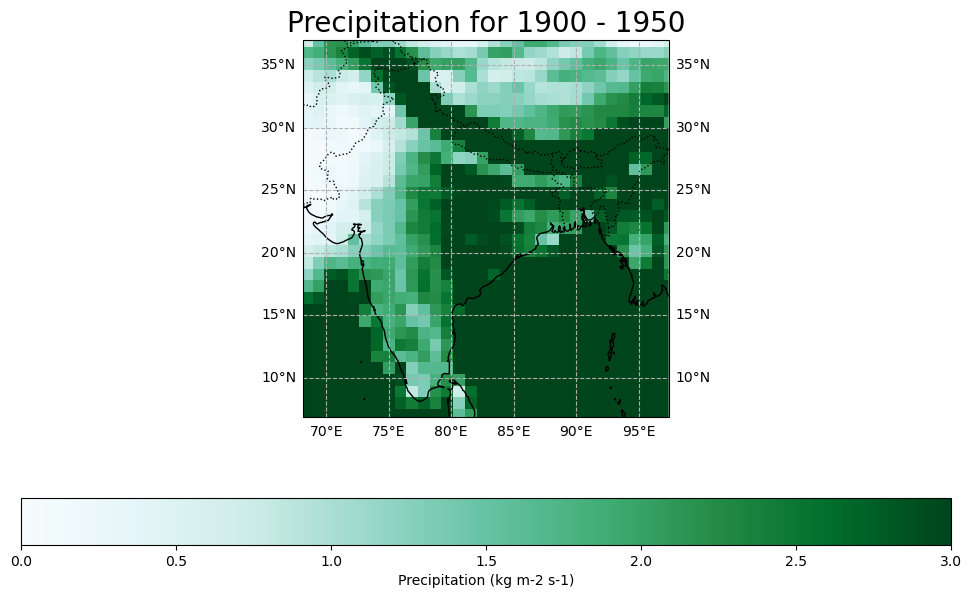

In [87]:
map_tr_hist_begin = 1900
map_tr_hist_end = 1950

plot_single(
    data = precip_zarr, 
    variable = variable[0], 
    time_range = f"{map_tr_hist_begin} - {map_tr_hist_end}")

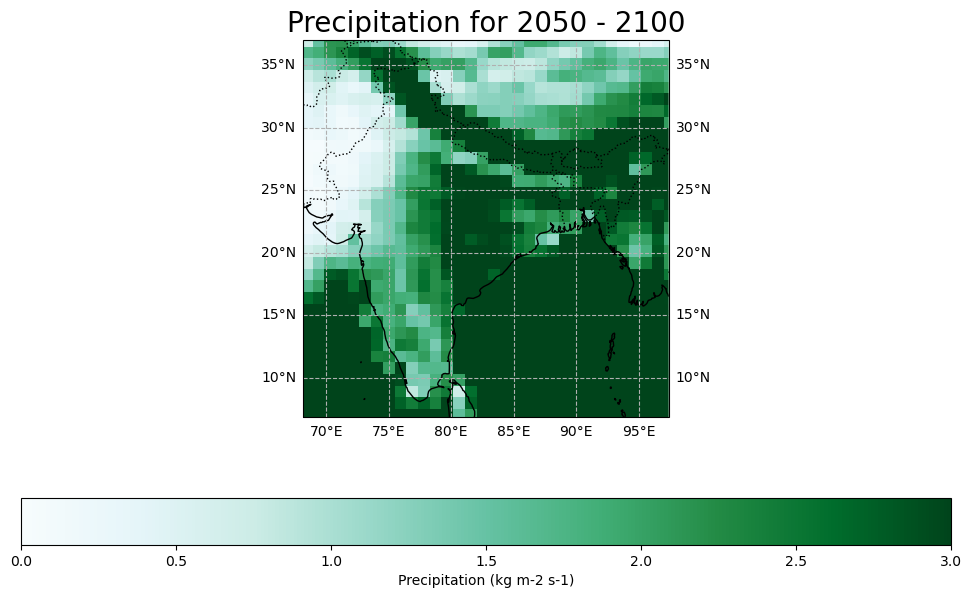

In [89]:
map_tr_sim_begin = 2050
map_tr_sim_end = 2100

plot_single(
    data = precip_zarr, 
    variable = variable[0], 
    time_range = f"{map_tr_sim_begin} - {map_tr_sim_end}")

In [ ]:
plot_single(
    data = rain_zarr, 
    variable = variable[0], 
    time_range = f"{map_tr_hist_begin} - {map_tr_hist_end}")

In [91]:
wind_zarr.sel

<xarray.Dataset>
Dimensions:   (lat: 192, bnds: 2, lon: 384)
Coordinates:
    height    float64 10.0
  * lat       (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
    lat_bnds  (lat, bnds) float64 -89.75 -88.82 -88.82 ... 88.82 88.82 89.75
  * lon       (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
    lon_bnds  (lon, bnds) float64 -0.4688 0.4688 0.4688 ... 358.6 358.6 359.5
Dimensions without coordinates: bnds
Data variables:
    sfcWind   (lat, lon) float64 dask.array<chunksize=(192, 384), meta=np.ndarray>